In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle,sys,os
import antropy as ant
from numpy import *
import heapq, qnorm
import ruptures as rpt
from scipy.stats import norm, pearsonr, zscore, rankdata
from sklearn.decomposition import PCA

In [2]:
with open('../../Human_hg38_chrom_ends.pkl','rb') as a:
    ENDS = pickle.load(a)

with open('../../Human_hg38_auto_10kb_windows.pkl','rb') as b:
    W = pickle.load(b)

In [3]:
df = pd.read_csv('3202_sequence_index.tsv',sep='\t')
runs = df['RUN_NAME'].tolist()
files = df['LIBRARY_NAME'].tolist()
sorted_files = sorted(files)
batches = [x.split('-')[-2] for x in runs]
bs = unique(batches)
BATCHES = {}
for batch in bs:
    idxs = [i for i in range(len(batches)) if batches[i]==batch]
    samples = array(files)[idxs]
    BATCHES[batch] = list(samples)

In [4]:
def get_numpy_arr(infile,columns=None):
    arr_file = load(infile)
    if columns is None:
        arr = arr_file['arr']
    else:
        arr = arr_file['arr'][:,columns]
    for cols in range(arr.shape[1]):
        csum = sum(arr[:,cols])
        arr[:,cols] /= csum
    return arr

def get_full_table(arr,win=10000):
    rows = 0
    full_table = []
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        full_table.append(arr[rows:rows+windows,:])
        rows += windows
    if rows!=arr.shape[0]:
        print('error')
    return full_table

def get_full_table_array_k_chr(full_table,win=10000,k=1):
    ends = []
    if k == 1:
        for ch in range(22):
            if ch == 0:
                arr = full_table[ch]
            else:
                arr = concatenate((arr,full_table[ch]),axis=0)
            ends.append(arr.shape[0])
    else:
        ft = []
        for ch in range(22):
            chrom = 'chr'+str(ch+1)
            bound = ENDS[chrom]
            win2 = win*k
            windows2 = bound // win2
            arr_i = full_table[ch]
            arr_k = zeros((windows2,arr_i.shape[1]))
            for j in range(windows2-1):
                arr_k[j] = arr_i[j*k:(j+1)*k,:].sum(axis=0)
            arr_k[-1] = arr_i[(windows2-1)*k:,:].sum(axis=0)
            if ch==0:
                arr = arr_k
            else:
                arr = concatenate((arr,arr_k),axis=0)
            ends.append(arr.shape[0])
    return arr, ends

def get_arr(infile,columns=None,k=1):
    df_arr = get_numpy_arr(infile,columns)
    table = get_full_table(df_arr)
    ftk, ends = get_full_table_array_k_chr(table,k=k)
    print(ends)
    return ftk #arrs

In [5]:
k = 1
thgs = get_arr('merged_table_no_correction_1000g_10kb.npz',k=k)
thgs.shape

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]


(287487, 3202)

In [6]:
brcas = get_arr('../../merged_table_no_correction_brca_10kb.npz',k=k)
crcs = get_arr('../../merged_table_no_correction_crc_10kb.npz',k=k)
ctrl29s = get_arr('../../merged_table_no_correction_ctrl29_10kb.npz',k=k)

ctrl38s = get_arr('../../merged_table_no_correction_ctrl38_10kb.npz',k=k)
ctdna36s = get_arr('../../merged_table_no_correction_ctdna36luad_10kb.npz',k=k)

ega8460 = get_arr('../../merged_table_no_correction_EGA8460_10kb.npz',k=k)
ega5343_ctrl = get_arr('../../merged_table_no_correction_EGA5343_ctrl_10kb.npz',k=k)

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 26

In [7]:
arr_file = load('../../merged_table_no_correction_EGA7080_10kb.npz')
samples = arr_file['samples']

ctrl = [i for i in range(len(samples)) if samples[i].startswith('Ctrl')]
ctdna = [i for i in range(len(samples)) if i not in ctrl] # and samples[i].endswith('_1')
ega7080_ctrl = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctrl,k=k)
ega7080_ctdna = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctdna,k=k)

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]


In [8]:
import gzip
nucleosomes = {}
# download at https://generegulation.org/NGS/stable_nucs/hg38/GSE81314_healthy_Song_stable_100bp_hg38.bed.gz
with gzip.open('GSE81314_healthy_Song_stable_100bp_hg38.bed.gz','r') as f:        
    for lines in f:        
        content = lines.decode().strip().split('\t')
        chrom = content[0]
        reg = (content[1],content[2])
        if chrom not in nucleosomes:
            nucleosomes[chrom] = []
        nucleosomes[chrom].append(reg)

allgenes = {}; pcgenes = {}; ncgenes={}
with open('Allgenes.bed','r') as f:        
    for lines in f:        
        content = lines.strip().split('\t')
        chrom = content[0]
        reg = (content[1],content[2])
        gtype = content[9].split('gene_type=')[1].split(';')[0]
        if gtype == 'protein_coding':
            if chrom not in pcgenes:
                pcgenes[chrom]=[]
            pcgenes[chrom].append(reg)
        else:
            if chrom not in ncgenes:
                ncgenes[chrom]=[]
            ncgenes[chrom].append(reg)
        if chrom not in allgenes:
            allgenes[chrom] = []
        allgenes[chrom].append(reg)

In [9]:
gcdict = {}
with open('gc_content10kb.txt','r') as f:        
    for lines in f:
        if lines.startswith('#'):
            continue
        content = lines.strip().split('\t')
        chrom = content[0]
        start = int(content[1])
        end = int(content[2])-1
        gc = float(content[4])
        record = (start,end,gc)
        if chrom not in gcdict:
            gcdict[chrom]=[]
        gcdict[chrom].append(record)

def get_gc_table(gcdict,size,win=10000):
    arr = zeros(size)
    offset = 0
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        for r in gcdict[chrom]:
            start = r[0];end = r[1];gc = r[2]
            w = start // win
            if offset+w>size:
                print(chrom,w)
                continue
            arr[offset+w]+=gc
        offset += windows
    if offset!=size:
        print('unmatched size',size,offset)
    return arr

In [10]:
def get_gene_table(genedict,size,win=10000):
    arr = zeros(size)
    offset = 0
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        if chrom not in genedict:
            offset += windows
            continue
        for r in genedict[chrom]:
            start = int(r[0])
            end = int(r[1])
            w1 = start // win
            w2 = end // win
            if offset+w1>size:
                print('error')
                continue
            for j in range(w1,w2+1):
                arr[offset+j]+=1
        offset += windows
    if offset!=size:
        print('unmatched size',size,offset)
    return arr

def get_nucleosome_table(size,win=10000):
    arr = zeros(size)
    offset = 0
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        for r in nucleosomes[chrom]:
            start = int(r[0])
            end = int(r[1])
            w1 = start // win
            w2 = end // win
            if offset+w1>size:
                continue
            if w1 == w2:
                arr[offset+w1]+=1
            else:
                #print(chrom,r)
                arr[offset+w1]+=1;arr[offset+w2]+=1
        offset += windows
    if offset!=size:
        print('unmatched size',size,offset)
    return arr

In [11]:
ends = [24895, 49114, 68943, 87964, 106117, 123197,139131, 153644, 167483, 180862, 
        194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
feats = [i for i in range(thgs.shape[0]) if sum(thgs[i,:])>0]
print(ends[-1]-len(feats))
#zf = [i for i in range(thgs.shape[0]) if i not in feats]
#print(len(zf))
chr_splits = [0]
j = 0
for e in ends:
    for i in range(j,len(feats)):
        if feats[i] > e:
            chr_splits.append(i)
            j = i
            break
chr_splits.append(len(feats))
print(chr_splits)

51248
[0, 21838, 43007, 61151, 77732, 93356, 108799, 122508, 135682, 146854, 158478, 170121, 181337, 190291, 197701, 205137, 211316, 216730, 222093, 226049, 231029, 233445, 236239]


In [12]:
gc = get_gc_table(gcdict,287487)
nucleosome = get_nucleosome_table(287487)
allgene = get_gene_table(allgenes,287487)
pcgene = get_gene_table(pcgenes,287487)
ncgene = get_gene_table(ncgenes,287487)

In [13]:
gc = gc[feats]
nucleosome = nucleosome[feats]
allgene = allgene[feats]
pcgene = pcgene[feats]
ncgene = ncgene[feats]

In [14]:
def get_rank(arr):
    ranked_arr = []
    for i in range(arr.shape[1]):
        ranked = rankdata(arr[:,i],'min')
        ranked_arr.append(ranked)
    return array(ranked_arr).T

In [15]:
rctrl38s = get_rank(ctrl38s[feats,:])
rctdna36s = get_rank(ctdna36s[feats,:])
rbrcas = get_rank(brcas[feats,:])
rcrcs = get_rank(crcs[feats,:])
rctrl29s = get_rank(ctrl29s[feats,:])
rega5343_ctrl = get_rank(ega5343_ctrl[feats,:])
rega7080_ctrl = get_rank(ega7080_ctrl[feats,:])
rega8460 = get_rank(ega8460[feats,:])
rega7080_ctdna = get_rank(ega7080_ctdna[feats,:])
#rthgs = get_rank(thgs[feats,:])

In [16]:
rthgs = get_rank(thgs[feats,:])

In [17]:
# segmentation
def get_breakpoints(arr=rthgs,splits=chr_splits):
    bkps = {}
    breaks = [0]
    offset = 0
    for ch in range(22):
        ctrl_signals = mean(arr[splits[ch]:splits[ch+1],:],axis=1)
        sigma = std(ctrl_signals)
        n = len(ctrl_signals)
        if n < 100:
            offset+=n
            continue
        algo = rpt.Binseg(model="l1",min_size=100).fit(ctrl_signals) # min size is 1Mbp # "l1", "rbf", "linear", "normal", "ar",...
        my_bkps = algo.predict(pen=log(n)*sigma)
        bkps['chr'+str(ch+1)] = [offset]+[x+offset for x in my_bkps]
        breaks += [x+offset for x in my_bkps]
        offset+= n
    return bkps, breaks
bkps, breaks = get_breakpoints()

In [18]:
rctrls = hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s))

In [19]:
rctdnas = hstack((rctdna36s,rega7080_ctdna,rbrcas,rcrcs,rega8460))

In [20]:
len(breaks)

1091

In [21]:
def segment_vs_genes(arr=rctrls,breaks=breaks,ref=rthgs):
    n = len(breaks)-1
    refseg = []; arrseg = []; nucseg = []; agseg = []; pcgseg = []; ncgseg = []; gcseg = []
    for i in range(n):
        ref_seg = median(mean(ref[breaks[i]:breaks[i+1],:],axis=0));refseg.append(ref_seg)
        arr_seg = median(mean(arr[breaks[i]:breaks[i+1],:],axis=0));arrseg.append(arr_seg)
        nuc_seg = mean(nucleosome[breaks[i]:breaks[i+1]]);nucseg.append(nuc_seg)
        allgene_seg = mean(allgene[breaks[i]:breaks[i+1]]);agseg.append(allgene_seg)
        pcgene_seg = mean(pcgene[breaks[i]:breaks[i+1]]);pcgseg.append(pcgene_seg)
        ncgene_seg = mean(ncgene[breaks[i]:breaks[i+1]]);ncgseg.append(ncgene_seg)
        gc_seg = mean(gc[breaks[i]:breaks[i+1]]);gcseg.append(gc_seg)
    return refseg,arrseg,nucseg,agseg,pcgseg,ncgseg,gcseg

refseg,arrseg,nucseg,agseg,pcgseg,ncgseg,gcseg = segment_vs_genes()

In [22]:
pearsonr(gcseg,[arrseg[i]/refseg[i] for i in range(len(refseg))])[0] # GC not correlated with cfDNA/gDNA ratio

-0.06711078728699378

In [23]:
pearsonr(agseg,[arrseg[i]/refseg[i] for i in range(len(refseg))])[0] # gene density weak negative correlation with cfDNA/gDNA ratio

-0.2329586655959353

In [24]:
pearsonr(nucseg,[arrseg[i]/refseg[i] for i in range(len(refseg))])[0] # nucleosome density insignificant correlation with cfDNA/gDNA ratio

0.1423102771390989

In [23]:
def region_lookup(pos_start,pos_end,wsize=10000,feats=feats,ends=ends):
    for i,e in enumerate(chr_splits):
        if pos_end <= e:
            ch = 'chr'+str(i)
            if i == 0:
                reg_start = wsize*feats[pos_start]+1
                reg_end = wsize*feats[pos_end]
            else:
                reg_start = wsize*(feats[pos_start]-feats[chr_splits[i-1]])+1
                reg_end = wsize*(feats[pos_end]-feats[chr_splits[i-1]])
            return ch+':'+str(reg_start)+'-'+str(reg_end)

In [24]:
region_lookup(217580,218660)

'chr18:35100001-45900000'

In [25]:
def find_over_represented_segment(arr=rctrls,breaks=breaks,ref=rthgs,topn=20):
    n = len(breaks)-1
    rs = []
    for i in range(n):
        ref_median = median(sum(ref[breaks[i]:breaks[i+1],:],axis=0))
        ratios = []
        for s in range(arr.shape[1]):
            segment = sum(arr[breaks[i]:breaks[i+1],s])
            ratio = segment/ref_median
            ratios.append(ratio)
        rs.append(median(ratios))
    topn_idx = argsort(rs)[::-1][:topn]
    return topn_idx, array(rs)[topn_idx]

In [26]:
topn_idx,ratios = find_over_represented_segment()
topn_idx,ratios

(array([904, 994,  93, 662, 995, 678,  19, 795, 957, 134, 944, 633, 834,
        738, 229,  59, 672, 287, 804, 619]),
 array([3.5283273 , 2.47031147, 2.31071887, 2.27152736, 2.22426934,
        2.12830867, 2.10139721, 2.10028626, 2.09618888, 2.07922722,
        2.07404233, 2.05941977, 2.05560123, 2.04682289, 2.03127588,
        2.00798418, 1.96647332, 1.96323897, 1.84951806, 1.83890049]))

In [27]:
topn_regions = [region_lookup(breaks[idx],breaks[idx+1]) for idx in topn_idx]
print(sorted(topn_regions))

['chr10:126000001-127800000', 'chr11:130560001-133760000', 'chr12:126550001-127950000', 'chr12:17150001-21250000', 'chr14:105470001-106950000', 'chr16:6100001-8100000', 'chr16:64740001-65740000', 'chr18:37600001-39100000', 'chr18:39100001-41400000', 'chr1:163490001-165190000', 'chr1:238120001-240270000', 'chr1:55390001-58040000', 'chr2:106500001-107900000', 'chr3:62400001-65900000', 'chr4:18450001-23350000', 'chr8:104460001-108160000', 'chr8:135710001-138510000', 'chr9:105920001-107020000', 'chr9:115120001-117570000', 'chr9:80270001-82420000']


In [28]:
def find_under_represented_segment(arr=rctrls,breaks=breaks,ref=rthgs,topn=20):
    n = len(breaks)-1
    rs = []
    for i in range(n):
        ref_mean = median(sum(ref[breaks[i]:breaks[i+1],:],axis=0))
        ratios = []
        for s in range(arr.shape[1]):
            segment = sum(arr[breaks[i]:breaks[i+1],s])
            ratio = segment/ref_mean
            ratios.append(ratio)
        rs.append(median(ratios))
    topn_idx = argsort(rs)[:topn]
    return topn_idx, array(rs)[topn_idx]

In [29]:
botn_idx,ratios2 = find_under_represented_segment()
botn_idx,ratios2

(array([ 507,   73,   42,  389,  184,  822,  382,  292, 1062,  478,  174,
         239,  317,  168,  477,  316,  171,  512,  547,  388]),
 array([0.41264324, 0.43799232, 0.48030615, 0.48446588, 0.498196  ,
        0.51637543, 0.52653706, 0.53050536, 0.53796323, 0.57512001,
        0.59248675, 0.59934379, 0.60007318, 0.60181834, 0.60315472,
        0.62186247, 0.62289164, 0.62585621, 0.62628816, 0.62803616]))

In [30]:
botn_regions = [region_lookup(breaks[idx],breaks[idx+1]) for idx in botn_idx]
print(sorted(botn_regions))

['chr12:90150001-91600000', 'chr1:101690001-102690000', 'chr1:191390001-192390000', 'chr21:24050001-25950000', 'chr2:180650001-182050000', 'chr2:189000001-190000000', 'chr2:192200001-195250000', 'chr2:212350001-213750000', 'chr3:102550001-105300000', 'chr4:111660001-113010000', 'chr4:113010001-114510000', 'chr4:34210001-35310000', 'chr5:88390001-89640000', 'chr5:97590001-99390000', 'chr5:99390001-101190000', 'chr6:114290001-115590000', 'chr6:115590001-116740000', 'chr7:119900001-121950000', 'chr7:19650001-20900000', 'chr7:8550001-9550000']


In [31]:
def segment_ratio_vs_nucleosome_median(arr=rctrls,breaks=breaks,ref=rthgs):
    n = len(breaks)-1
    rs = []; gs=[]; ns = []; ags = []; pgs = []; ngs = []
    for i in range(n):
        ref_median = median(sum(ref[breaks[i]:breaks[i+1],:],axis=0))
        arr_median = median(sum(arr[breaks[i]:breaks[i+1],:],axis=0))
        nuc_seg = mean(nucleosome[breaks[i]:breaks[i+1]])
        ag_seg = mean(allgene[breaks[i]:breaks[i+1]])
        pg_seg = mean(pcgene[breaks[i]:breaks[i+1]])
        ng_seg = mean(ncgene[breaks[i]:breaks[i+1]])
        ns.append(nuc_seg);ags.append(ag_seg);pgs.append(pg_seg);ngs.append(ng_seg);
        rs.append(arr_median/ref_median)
        #ratios = []
        #for s in range(arr.shape[1]):
        #    segment = sum(arr[breaks[i]:breaks[i+1],s])
        #    ratio = segment/ref_median
        #    ratios.append(ratio)
        #rs.append(median(ratios))
    return rs,ns,ags,pgs,ngs

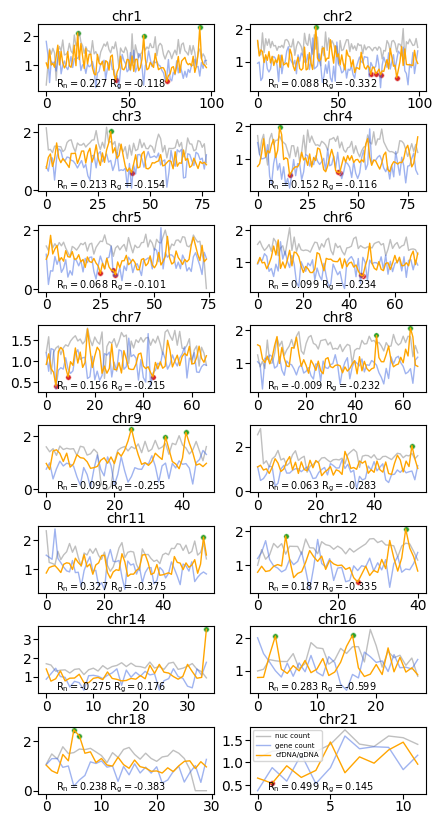

In [32]:
#refseg,arrseg,nucseg,agseg,pcgseg,ncgseg = segment_vs_genes()
import matplotlib as mpl
cmap = mpl.colormaps['Spectral_r']
# Take colors at regular intervals spanning the colormap.
colors = cmap(linspace(0, 1, 4))
sns.set_context(context=None, font_scale=1, rc={'legend.fontsize': 5, 'legend.position':'upper left'})
def plot_segment_vs_genes_nucleosome(arr=rctrls,ref=rthgs,figname=None):
    fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(5, 10))
    plt.subplots_adjust(hspace=0.5)
    for ch, ax in zip([1,2,3,4,5,6,7,8,9,10,11,12,14,16,18,21], axs.ravel()):
        chrom = 'chr'+str(ch)
        rs,ns,ags,pgs,ngs = segment_ratio_vs_nucleosome_median(breaks=bkps[chrom])
        coef_n = round(pearsonr(ns,rs)[0],3); coef_g = round(pearsonr(ags,rs)[0],3)
        #ax.annotate('R='+str(round(r0,3)), (0.1, 0.8), xycoords='axes fraction')
        text = r'$\mathregular{R_n}=$'+str(coef_n)+' '+r'$\mathregular{R_g}=$'+str(coef_g)
        ax.set_title(chrom,fontdict={'fontsize':10},pad=1);ax.annotate(text,(0.1, 0.05), xycoords='axes fraction',fontsize=7)
        ax.tick_params(pad=1)
        if ch == 21:
            sns.lineplot(x=range(len(ns)),y=ns,lw=1,color='grey',alpha=0.5,label='nuc count',ax=ax)
            sns.lineplot(x=range(len(ns)),y=ags,lw=1,color='royalblue',alpha=0.5,label='gene count',ax=ax)
            sns.lineplot(x=range(len(ns)),y=rs,lw=1,color='orange',label='cfDNA/gDNA',ax=ax)
        else:
            sns.lineplot(x=range(len(ns)),y=ns,lw=1,color='grey',alpha=0.5,ax=ax)
            sns.lineplot(x=range(len(ns)),y=ags,lw=1,color='royalblue',alpha=0.5,ax=ax)
            sns.lineplot(x=range(len(ns)),y=rs,lw=1,color='orange',ax=ax)
        xs = [];ys = []
        for idx in topn_idx:
            if breaks[idx] in bkps[chrom]:
                x = bkps[chrom].index(breaks[idx]);y = rs[x];xs.append(x);ys.append(y)
            sns.scatterplot(x=xs,y=ys,ax=ax,color='C2',s=15)
        xs = [];ys = []
        for idx in botn_idx:
            if breaks[idx] in bkps[chrom]:
                x = bkps[chrom].index(breaks[idx]);y = rs[x];xs.append(x);ys.append(y)
            sns.scatterplot(x=xs,y=ys,ax=ax,color='C3',s=15)
    plt.legend(loc='upper left')
    if not figname is None:
        fig.savefig(figname,bbox_inches='tight',dpi=150) #
plot_segment_vs_genes_nucleosome()
#plot_segment_vs_genes_nucleosome(figname='new_figures/fig.gDNA_vs_cfDNA_seg_vs_gene_nuc_lineplot.png')

In [33]:
def segment_miu_var(arr=rctrls,breaks=breaks):
    n = len(breaks)-1
    arr_miu = []; arr_var = []
    for s in range(arr.shape[1]): #s for samples
        arrseg = []
        for i in range(n):
            arr_segment = mean(arr[breaks[i]:breaks[i+1],s])  # segment rank
            arrseg.append(arr_segment)
        arr_miu.append(mean(arrseg)); arr_var.append(var(arrseg))    
    return arr_miu,arr_var

def window_miu_var(arr=rctrls,breaks=breaks):
    start = breaks[0]; end = breaks[-1]
    arr_miu = []; arr_var = []
    for s in range(arr.shape[1]): #s for samples
        arr_miu.append(mean(arr[start:end,s])); arr_var.append(var(arr[start:end,s]))    
    return arr_miu,arr_var

In [34]:
import matplotlib as mpl
cmap = mpl.colormaps['Spectral_r']
# Take colors at regular intervals spanning the colormap.
colors = cmap(linspace(0, 1, 6))

import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 3))

In [35]:
viz_dict = {'ytick.labelsize':7.5, 'xtick.labelsize':7.5, 'font.size':8.5} 
sns.set_context(context=None, font_scale=1, rc=viz_dict)
def plot_segment_window_miu_var(arr=rthgs,figname=None,s=1):
    fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(8, 4))
    plt.subplots_adjust(hspace=0.5)
    for ch in range(1,7):
        chrom = 'chr'+str(ch)
        axs[0,0].set_title('gDNA chr rank dist by segment',fontdict={'fontsize':10},pad=1) #
        #axs[0,0].set_xlabel('mean of segment ranks');axs[0,0].set_ylabel('var of segment ranks');axs[0,0].tick_params(pad=1)
        arr_miu,arr_var = segment_miu_var(arr=arr,breaks=bkps[chrom])
        axs[0,0].scatter(arr_miu,arr_var,color=colors[ch-1],label=chrom,s=s,alpha=.75)
        axs[0,0].set_xlim(80000,130000);axs[0,0].set_ylim(0,4.5e9)
        axs[1,0].set_title('cfDNA chr rank dist by segment',fontdict={'fontsize':10},pad=1) #
        axs[1,0].set_xlabel('mean of segment ranks');axs[1,0].set_ylabel('var of segment ranks');axs[1,0].tick_params(pad=1)
        arr_miu,arr_var = segment_miu_var(arr=rctrls,breaks=bkps[chrom])
        axs[1,0].scatter(arr_miu,arr_var,color=colors[ch-1],label=chrom,s=s,alpha=.75)
        axs[1,0].set_xlim(80000,130000);axs[1,0].set_ylim(0,4.5e9)        
    for ch in range(1,7):
        chrom = 'chr'+str(ch)
        axs[0,1].set_title('gDNA chr rank dist by window',fontdict={'fontsize':10},pad=1) #
        #axs[0,1].set_xlabel('mean of window ranks');axs[0,1].set_ylabel('var of window ranks');axs[0,1].tick_params(pad=1)
        arr_miu,arr_var = window_miu_var(arr=arr,breaks=bkps[chrom])
        axs[0,1].scatter(arr_miu,arr_var,color=colors[ch-1],label=chrom,s=s,alpha=.75)
        axs[0,1].set_xlim(80000,140000);axs[0,1].set_ylim(2e9,6.3e9)
        axs[1,1].set_title('cfDNA chr rank dist by window',fontdict={'fontsize':10},pad=1) #
        axs[1,1].set_xlabel('mean of window ranks');axs[1,1].set_ylabel('var of window ranks');axs[1,1].tick_params(pad=1)
        arr_miu,arr_var = window_miu_var(arr=rctrls,breaks=bkps[chrom])
        axs[1,1].scatter(arr_miu,arr_var,color=colors[ch-1],label=chrom,s=s,alpha=.75)
        axs[1,1].set_xlim(80000,140000);axs[1,1].set_ylim(2e9,6.3e9)
    plt.legend(loc='upper left')#fontsize=10
    if not figname is None:
        fig.savefig(figname,bbox_inches='tight',dpi=120) #

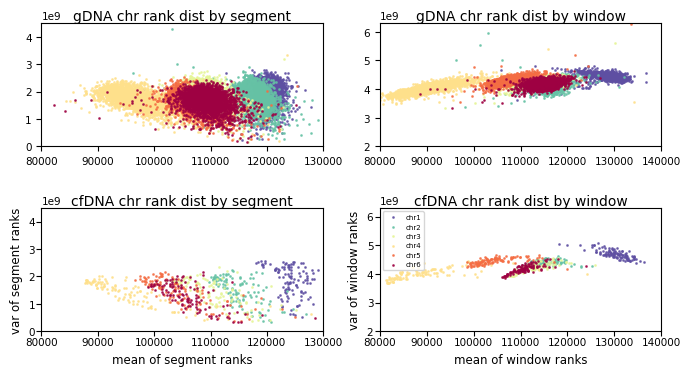

In [36]:
#plot_segment_window_miu_var(figname='new_figures/fig.gDNA_vs_cfDNA_seg_vs_window_chr1-6.png')
plot_segment_window_miu_var()

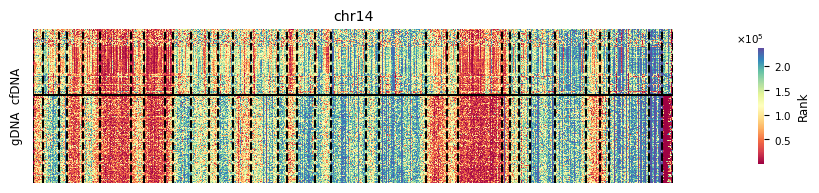

In [37]:
plt.figure(figsize=(11,2))
chrom='chr14'
plt.title(chrom)
arr = vstack((rctrls.T,rthgs.T[:150,:]))
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr[:,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Rank',location="right",pad=0.1,shrink=.75,format=formatter),
                 robust=True,cmap="Spectral",vmin=1,vmax=236239)
ax.tick_params(left=False,bottom=False,pad=0);ax.set(ylabel='gDNA  cfDNA',xticklabels=[],yticklabels=[])
ax.hlines([rctrls.shape[1]], *ax.get_xlim(),colors='black')
ax.vlines([x-bkps[chrom][0] for x in bkps[chrom]],colors='black',linestyles='dashed',*ax.get_ylim())
#plt.savefig('new_figures/fig.chr14-segment-heatmap2.png',bbox_inches='tight',dpi=120)

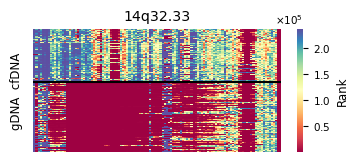

In [38]:
plt.figure(figsize=(4,1.6))
chrom='chr14'
plt.title('14q32.33')
arr = vstack((rctrls.T[:,197581:197701],rthgs.T[:150,197581:197701]))
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr,cbar_kws = dict(label='Rank',location="right",shrink=1,format=formatter),robust=True,cmap="Spectral",vmin=1,vmax=236239)
ax.tick_params(left=False,bottom=False,pad=0);ax.set(ylabel='gDNA  cfDNA',xticklabels=[],yticklabels=[])
ax.hlines([rctrls.shape[1]], *ax.get_xlim(),colors='black')
#lines = [x for x in bkps[chrom] if x>197384 and x<197701]
#ax.vlines(array(lines)-197384,colors='black',linestyles='dashed',*ax.get_ylim())
#plt.savefig('new_figures/fig.IGH_locus_only.png',bbox_inches='tight',dpi=120)

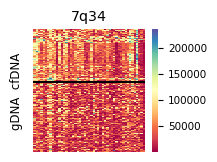

In [39]:
plt.figure(figsize=(1.8,1.6))
chrom='chr7'
plt.title('7q34')
arr = vstack((rctrls.T[:,110184:110233],rthgs.T[:150,110184:110233]))
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr,robust=True,cmap="Spectral",vmin=1,vmax=236239)
ax.tick_params(left=False,bottom=False,pad=0);ax.set(ylabel='gDNA  cfDNA',xticklabels=[],yticklabels=[])
ax.hlines([rctrls.shape[1]], *ax.get_xlim(),colors='black')
#plt.savefig('new_figures/fig.TRB_locus.png',bbox_inches='tight',dpi=120)

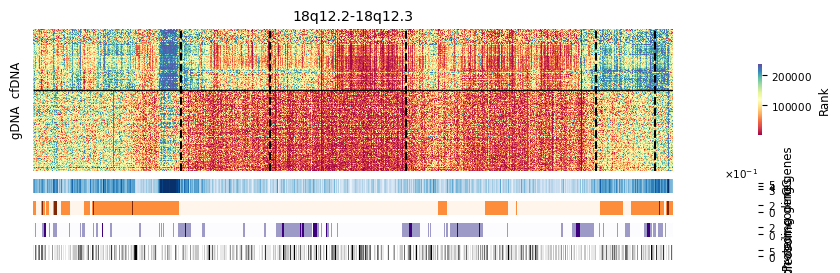

In [40]:
#plt.figure()
chrom='chr18'
#plt.title('18q12.2-18q12.3')
arr = vstack((rctrls.T[:,217580:218660],rthgs.T[:150,217580:218660]))
ch = int(chrom.split('hr')[1])-1
f, (a0, a1, a2, a3, a4) = plt.subplots(5, 1, figsize=(11,3), height_ratios=[2, .2, .2, .2, .2])
#plt.title(chrom)
sns.heatmap(arr,cbar_kws = dict(label='Rank',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap="Spectral",vmin=1,vmax=236239,ax=a0)
a0.tick_params(left=False,bottom=False,pad=0);a0.set(ylabel='gDNA  cfDNA',xticklabels=[],yticklabels=[],title='18q12.2-18q12.3') #ylabel='gDNA  cfDNA',
a0.hlines([rctrls.shape[1]], *a0.get_xlim(),colors='black',linewidth=1)
lines = [x for x in bkps[chrom] if x>217580 and x<218660]
a0.vlines(array(lines)-217580,colors='black',linestyles='dashed',*a0.get_ylim())
#a0.vlines([x-bkps[chrom][0] for x in bkps[chrom]],colors='black',linewidth=1,linestyles='dashed',*a0.get_ylim())

arr2 = array([gc,pcgene,ncgene,nucleosome])
sns.heatmap(arr2[:1,217580:218660],cbar_kws = dict(label='GC',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap='Blues',vmin=0.3,ax=a1)
a1.tick_params(left=False,bottom=False,pad=0);a1.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[1:2,217580:218660],cbar_kws = dict(label='Protein-coding genes',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap='Oranges',vmin=0,vmax=2,ax=a2)
a2.tick_params(left=False,bottom=False,pad=0);a2.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[2:3,217580:218660],cbar_kws = dict(label='Non-coding genes',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap='Purples',ax=a3)
a3.tick_params(left=False,bottom=False,pad=0);a3.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[3:4,217580:218660],cbar_kws = dict(label='Nucleosome',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap='Greys',ax=a4)
a4.tick_params(left=False,bottom=False,pad=0);a4.set(xticklabels=[],yticklabels=[])
plt.show()
#plt.savefig('new_figures/fig.18q12.2-3.with-anno.png',bbox_inches='tight',dpi=120)

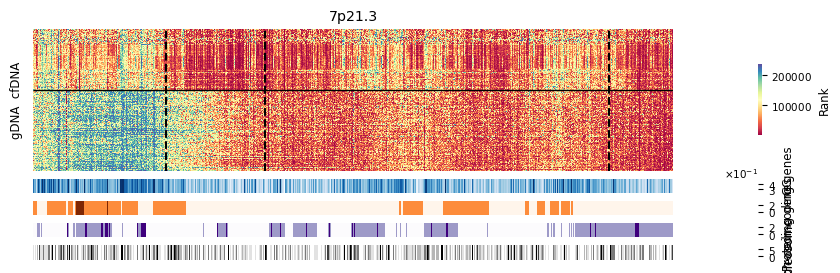

In [41]:
#plt.figure()
chrom='chr7'
#plt.title('7p21.3')
arr = vstack((rctrls.T[:,109519:110169],rthgs.T[:150,109519:110169]))
ch = int(chrom.split('hr')[1])-1
f, (a0, a1, a2, a3, a4) = plt.subplots(5, 1, figsize=(11,3), height_ratios=[2, .2, .2, .2, .2])
#plt.title(chrom)
sns.heatmap(arr,cbar_kws = dict(label='Rank',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap="Spectral",vmin=1,vmax=236239,ax=a0)
a0.tick_params(left=False,bottom=False,pad=0);a0.set(ylabel='gDNA  cfDNA',xticklabels=[],yticklabels=[],title='7p21.3') #ylabel='gDNA  cfDNA',
a0.hlines([rctrls.shape[1]], *a0.get_xlim(),colors='black',linewidth=1)
lines = [x for x in bkps[chrom] if x>109519 and x<110169]
a0.vlines(array(lines)-109519,colors='black',linestyles='dashed',*a0.get_ylim())
#a0.vlines([x-bkps[chrom][0] for x in bkps[chrom]],colors='black',linewidth=1,linestyles='dashed',*a0.get_ylim())

arr2 = array([gc,pcgene,ncgene,nucleosome])
sns.heatmap(arr2[:1,109519:110169],cbar_kws = dict(label='GC',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap='Blues',vmin=0.3,ax=a1)
a1.tick_params(left=False,bottom=False,pad=0);a1.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[1:2,109519:110169],cbar_kws = dict(label='Protein-coding genes',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap='Oranges',vmin=0,vmax=2,ax=a2)
a2.tick_params(left=False,bottom=False,pad=0);a2.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[2:3,109519:110169],cbar_kws = dict(label='Non-coding genes',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap='Purples',ax=a3)
a3.tick_params(left=False,bottom=False,pad=0);a3.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[3:4,109519:110169],cbar_kws = dict(label='Nucleosome',location="right",pad=0.1,shrink=0.5,format=formatter),
                 robust=True,cmap='Greys',ax=a4)
a4.tick_params(left=False,bottom=False,pad=0);a4.set(xticklabels=[],yticklabels=[])
plt.show()
#plt.savefig('new_figures/fig.7p21.3.with-anno.png',bbox_inches='tight',dpi=120)

In [42]:
def window_ratio_median(idxs,arr=rctrls,ref=rthgs):
    rs = []
    for i in idxs:
        ref_median = median(ref[i,:],axis=0)
        arr_median = median(arr[i,:],axis=0)
        ratio = arr_median/ref_median
        rs.append(ratio)
    return rs

In [45]:
#import matplotlib as mpl
cmap = mpl.colormaps['Spectral']
cmapr = mpl.colormaps['Spectral_r']
# Take colors at regular intervals spanning the colormap.
colors = cmap(linspace(0, 1, 13))
#colors_r = cmapr(linspace(0, 1, 13)) #mpl.colors.rgb2hex(c)
from matplotlib.patches import PathPatch
from statannot import add_stat_annotation

In [68]:
genic = [i for i in range(len(allgene)) if allgene[i]>0]
intergenic = [i for i in range(len(allgene)) if allgene[i]==0]
intergenic_rs = window_ratio_median(intergenic)
genic_rs = window_ratio_median(genic)

pcgenic = [i for i in range(len(allgene)) if pcgene[i]>0]
ncgenic = [i for i in range(len(allgene)) if pcgene[i]==0 and ncgene[i]>0]
pcgenic_rs = window_ratio_median(pcgenic)
ncgenic_rs = window_ratio_median(ncgenic)
nucl = [i for i in range(len(allgene)) if nucleosome[i]>0]
non_nucl = [i for i in range(len(allgene)) if nucleosome[i]==0]
nucl_rs = window_ratio_median(nucl)
non_nucl_rs = window_ratio_median(non_nucl)

In [70]:
data = {'group':[],'ratio':[],'type':[]}

data['group']+=['nucleosome+/-']*len(nucl_rs)
data['ratio']+=nucl_rs
data['type']+=['pos']*len(nucl_rs)
data['group']+=['nucleosome+/-']*len(non_nucl_rs)
data['ratio']+=non_nucl_rs
data['type']+=['neg']*len(non_nucl_rs)

data['group']+=['genic/intergenic']*len(intergenic_rs)
data['ratio']+=intergenic_rs
data['type']+=['neg']*len(intergenic_rs)
data['group']+=['genic/intergenic']*len(genic_rs)
data['ratio']+=genic_rs
data['type']+=['pos']*len(genic_rs)

data['group']+=['pcgene/ncgene']*len(pcgenic_rs)
data['ratio']+=pcgenic_rs
data['type']+=['pos']*len(pcgenic_rs)
data['group']+=['pcgene/ncgene']*len(ncgenic_rs)
data['ratio']+=ncgenic_rs
data['type']+=['neg']*len(ncgenic_rs)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

genic/intergenic_pos v.s. genic/intergenic_neg: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=4.849e+09
nucleosome+/-_pos v.s. nucleosome+/-_neg: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.005e-13 U_stat=6.079e+09
pcgene/ncgene_pos v.s. pcgene/ncgene_neg: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=2.349e+09


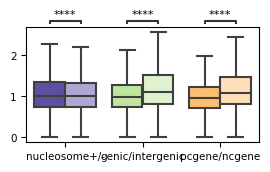

In [75]:
fig, ax = plt.subplots(figsize=(3, 1.5))
hue_order = ['pos', 'neg']
#colors = ['violet','royalblue','orangered','forestgreen','sienna','gold','navy','violet','royalblue','orangered','forestgreen','sienna','gold']
sns.boxplot(data=data, x="group", y="ratio",hue="type",showfliers = False, hue_order=hue_order, ax=ax)
colors_r = cmapr(linspace(0, 1, 4))
box_colors = [f + (1 - f) * array(mpl.colors.to_rgb(c)) for c in colors_r for f in linspace(0, 0.5, len(hue_order))]
box_patches = [p for p in ax.patches if isinstance(p, PathPatch)]
for patch, color in zip(box_patches, box_colors):
    patch.set_facecolor(color)
ax.get_legend().remove()
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
box_pairs=[
    (("nucleosome+/-", "pos"), ("nucleosome+/-", "neg")),
    (("genic/intergenic", "pos"), ("genic/intergenic", "neg")),
    (("pcgene/ncgene", "pos"), ("pcgene/ncgene", "neg")),
    ]
add_stat_annotation(ax,data=data,x='group',y='ratio',hue='type',box_pairs=box_pairs,
                    perform_stat_test=True,test='Mann-Whitney',text_format='star',loc='outside', fontsize=8,verbose=1)
#fig.savefig('new_figures/fig.genic_intergenic_boxplot.png',bbox_inches='tight',dpi=120)